# BatchNorm as Noise Injection
- There is a recent shift in understanding about what BN actually does under the hood
- Initially the concensus was to view it from an optimisation and signal propagation point of view, now it is shifting towards noise injection
- This is a short notebook focused on a qualitative analysis using toy problems, anecdotal examples and visualisations to build intuition
- The batch normalisation part of BN can be seen as a form of data augmentation - each data point is being displaced/perturbed/transformed
- The hyper-parameter affecting a data point's displacement is the batch size. [e.g discussed in 4 Things to improve BN - Summers 2019]
    - The smaller the batch size the more variability there is in batch statsitics and therefore where the data point will end up after normalisation. 
    - The larger the batch size the more stable the stats become, leading to less displacement.
- This can be contrasted with simply adding white noise to a data point, which is what we will do in this notebook
- [Momentum Batchnom - Yong 2020] Goes as far as proving what distribution BN samples noise from.
    - I have my doubts that one can define a noise distribution, which is equivalent to BN, but that doesn't take the data manifold into consideration. Yes, it will be centered around the data point, however I would suspect it's shape should defined by where the mass of the rest of the data points lies. 
    - E.g Adding white noise will perturb the data point equally in all directions. But if the datapoint is an outlier, most certainly all BN augmentations will lie on the side where the rest of the data is located.
    - This might be inconsequential in practical terms, it's just an opinion from a theoretical point of view.
- In this notebook we will look at 1) how a single data point is displaced/augmented; 2) how a whole dataset is being augmented and 3) it's effects on the dataset density and 4) decision boundary.
- To visualise we will use a 2D half-moon dataset with varying degrees of noise (overlapping classes).
- To emphasize the effects of augmentation, the dataset will be very small with a large sample of augmented datapoints.
- Overall from a qualitative point of view, BN augmentation and noise injection seem to be very similar; which suports the hypothesis
- For a quantitative analysis too many things would need to be taked into cosideration (more complicated data manifolds, deep networks) which would make plotting not possible.
- Just from this analysis I would lean towards thinking that yes, BN is a form of data augmentation via noise injection. And while just adding noise wouldn't be exactly the same thing, I wouldn't be surprised if the results would still be as competitive.
    - For the majority of the data points the data augmentation doesn't really matter. It's the ones one the decision boundary that define the model's performance.

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

# 0. Data
- Simple 2D halfmoons dataset
- Normalised so that mean=0, std=1
- Generating few data points so we can sample a lot more when augmenting
- Noise can control the difficulty of the decision boundary

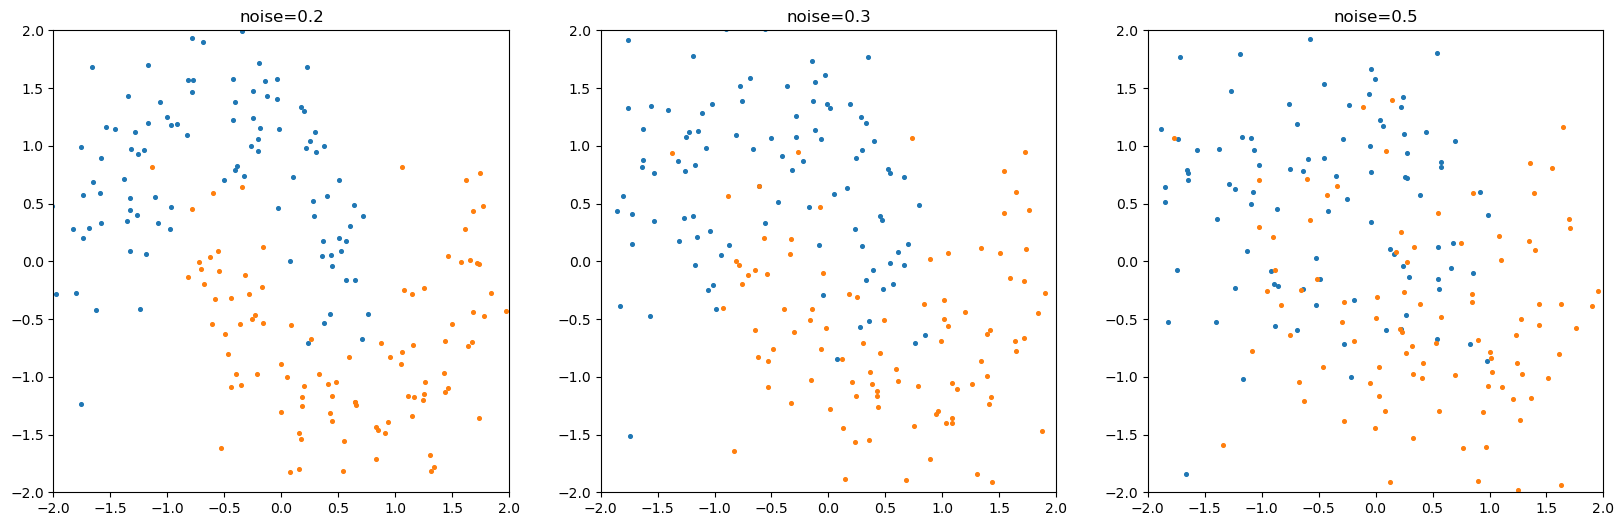

In [82]:
def get_data(n_samples=200, noise=0.1):
    X, y = make_moons(n_samples=n_samples, noise=noise, random_state=0)
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    return X, y

def plot_data(X, y, ax=None, title="", alpha=1):
    if ax is None:
        _, ax = plt.subplots(1,1)
    ax.scatter(X[:,0][y==0], X[:,1][y==0], s=7, alpha=alpha)
    ax.scatter(X[:,0][y==1], X[:,1][y==1], s=7, alpha=alpha)
    ax.set_xlim(-2,2)
    ax.set_ylim(-2,2)
    ax.set_title(title)

fig, axarr = plt.subplots(1, 3, figsize=(20, 6))
plot_data(*get_data(noise=0.2), ax=axarr[0], title="noise=0.2")
plot_data(*get_data(noise=0.3), ax=axarr[1], title="noise=0.3")
plot_data(*get_data(noise=0.5), ax=axarr[2], title="noise=0.5")

In [8]:
def batch_normalise(Xs: list):
    return [(X - X.mean(axis=0)) / X.std(axis=0) for X in Xs]

def gaussian_noise(Xs, std=0.1):
    return [X + np.random.normal(loc=0.0, scale=std, size=X.shape)for X in Xs]

def get_batches(X, y, batch_size=10, n_samples=1000):
    n_iter = n_samples // batch_size
    batch_ixs = [np.random.choice(range(len(X)), size=batch_size, replace=False) for _ in range(n_iter)]
    res_X = [X[ixs] for ixs in batch_ixs]
    res_y = [y[ixs] for ixs in batch_ixs]
    return res_X, res_y

def plot_samples(X, y, ax=None):
    X = np.concatenate(X)
    y = np.concatenate(y)

    if ax is None:
        _, ax = plt.subplots(1,1)
    ax.scatter(X[:,0][y==0], X[:,1][y==0], c="lightgreen", alpha=0.7, s=3,)
    ax.scatter(X[:,0][y==1], X[:,1][y==1], c="orange", alpha=0.7, s=3,)

# 1. Transformation of a single data point
- Performs regular batchnorm normalisation but plot only where the point would end up
- Indeed, the smaller the batch-size the farther away a single data point would be displaced
- Displacement is centered around original location. However, intuitively it seems the displacement/noise distribution is determined by the data manifold. Don't think one can make a claim it is data independent.

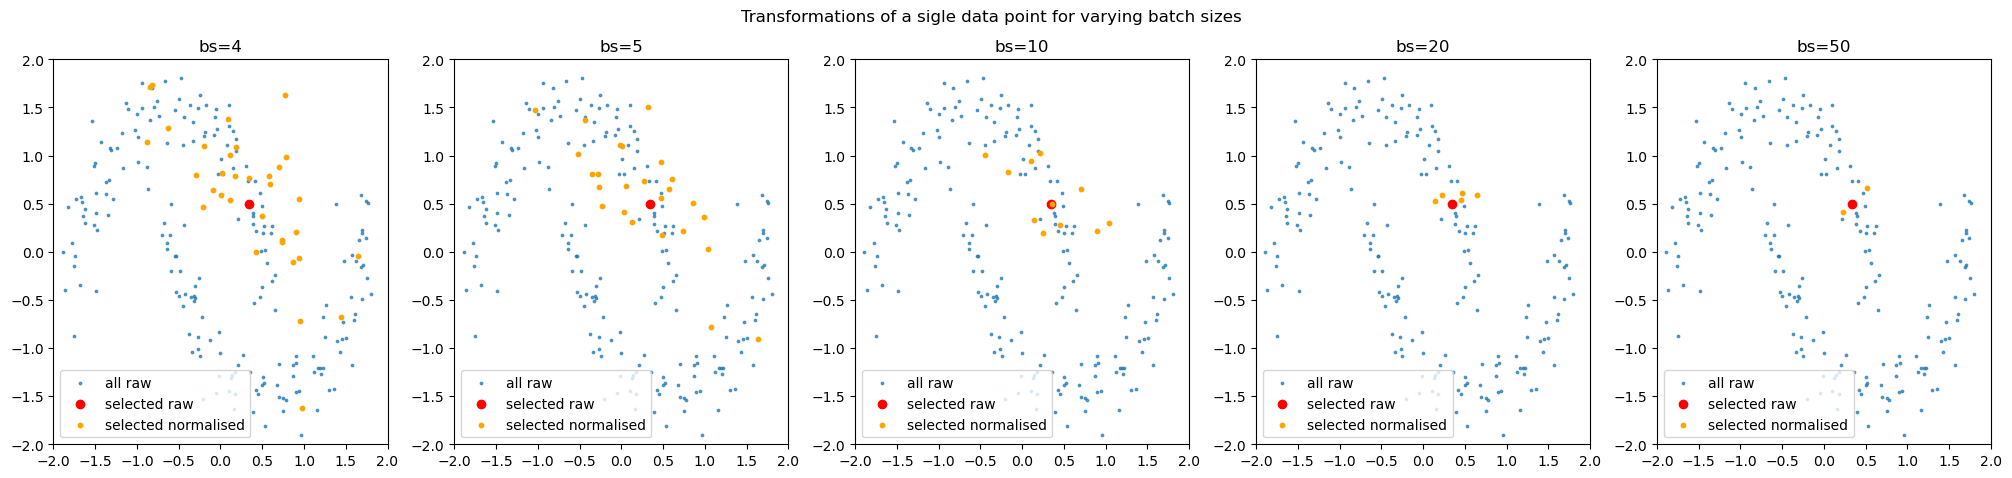

In [96]:
fig, axarr = plt.subplots(1, 5, figsize=(25, 5))
fig.suptitle("Transformations of a sigle data point for varying batch sizes")

X, y = get_data(noise=0.1)
for ix, batch_size in enumerate([4, 5, 10, 20, 50]):
    ax = axarr[ix]
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_title(f"bs={batch_size}")
    np.random.seed(0)
    Xs, ys = get_batches(X, y, batch_size=batch_size-1, n_samples=100)
    Xs = [np.vstack([X[0], X_]) for X_ in Xs]
    Xs = batch_normalise(Xs)
    ax.scatter(X[:,0], X[:,1], s=3, alpha=0.7, label="all raw")
    ax.scatter(X[0,0], X[0,1], c="red", label="selected raw")
    Xs = np.vstack([X_[0] for X_ in Xs])
    ax.scatter(Xs[:,0], Xs[:,1], c="orange", s=10, label="selected normalised")
    ax.legend()

# 2. Augmentation of a dataset
- Plot the augmented dataset using BN or gaussian noise
- Vary noise level via batch-size for BN and std for white noise
- Plots look very similar for most noise levels

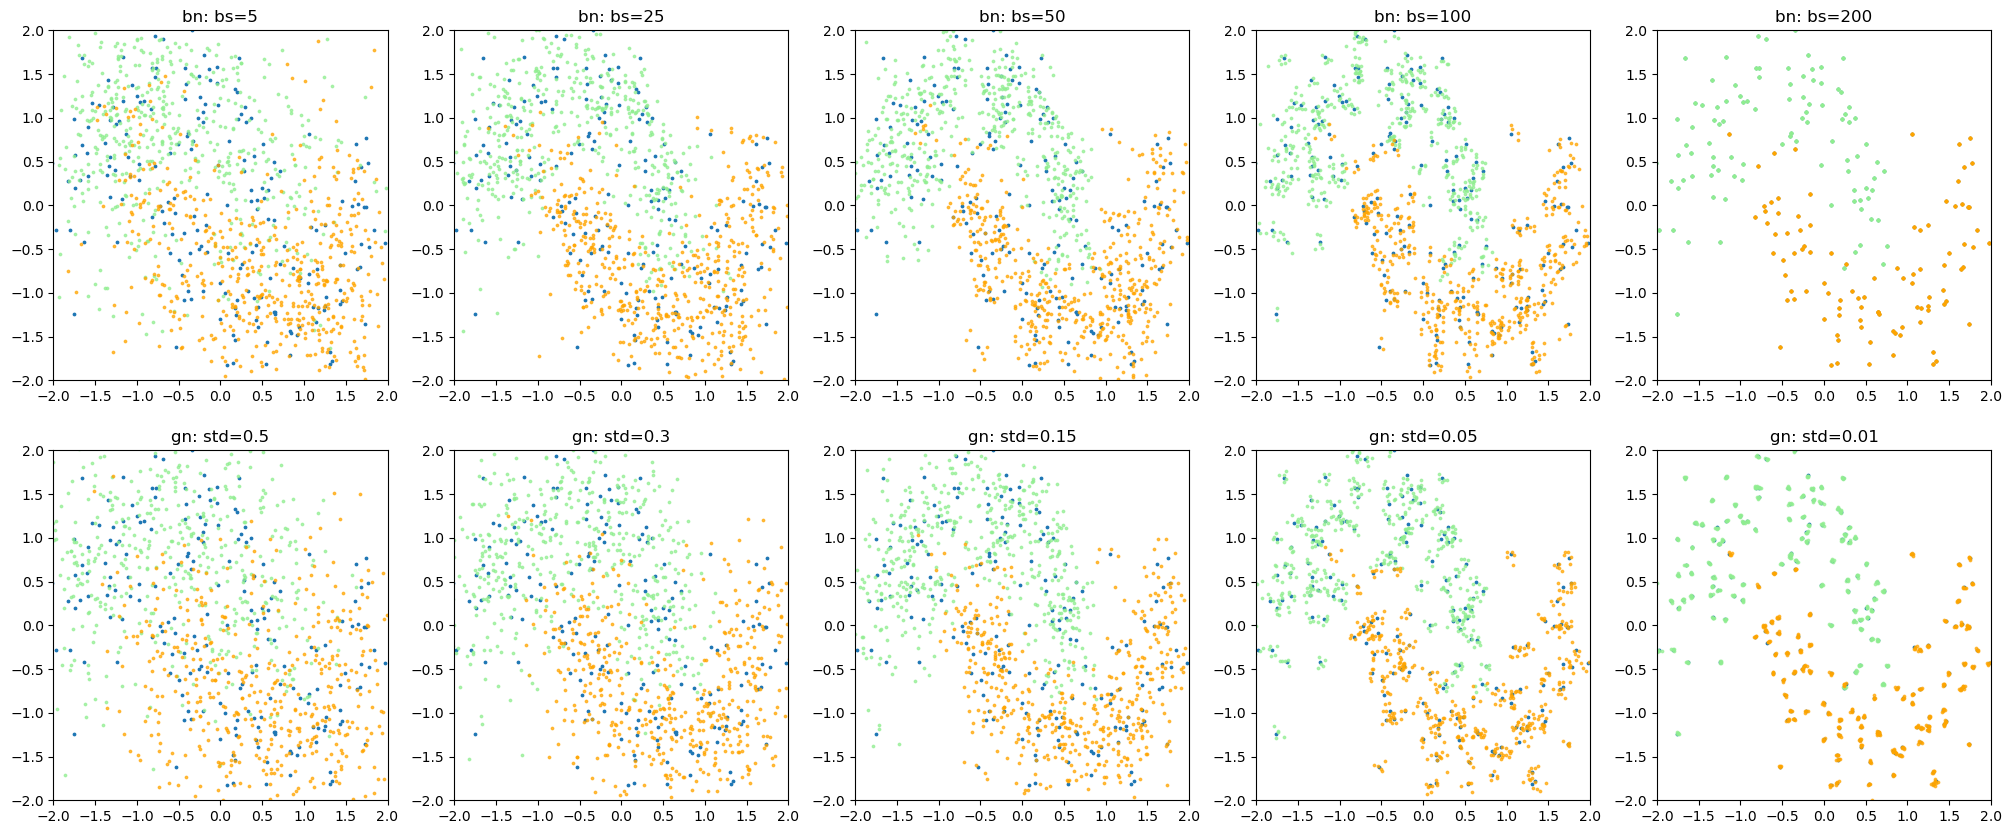

In [61]:
fig, axarr = plt.subplots(2, 5, figsize=(25, 10))
X, y = get_data(noise=0.2)

for ix, batch_size in enumerate([5, 25, 50, 100, 200]):
    ax = axarr[0, ix]
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_title(f"bn: bs={batch_size}")
    np.random.seed(0)
    Xs, ys = get_batches(X, y, batch_size=batch_size)
    Xs = batch_normalise(Xs)
    ax.scatter(X[:,0], X[:,1], s=3)
    plot_samples(Xs, ys, ax=ax)


for ix, std in enumerate([0.5, 0.3, 0.15, 0.05, 0.01]):
    ax = axarr[1, ix]
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_title(f"gn: std={std}")
    np.random.seed(0)
    Xs, ys = get_batches(X, y, batch_size=batch_size)
    Xs = gaussian_noise(Xs, std=std)
    ax.scatter(X[:,0], X[:,1], s=3)
    plot_samples(Xs, ys, ax=ax)

# 3. Effects on Density
- Increasing noise and number of augmented samples [20x] to accentuate effects
- Qualitatively I can't say there is a big difference. I am sure there is one but without quantitative experiments we can't say for sure.

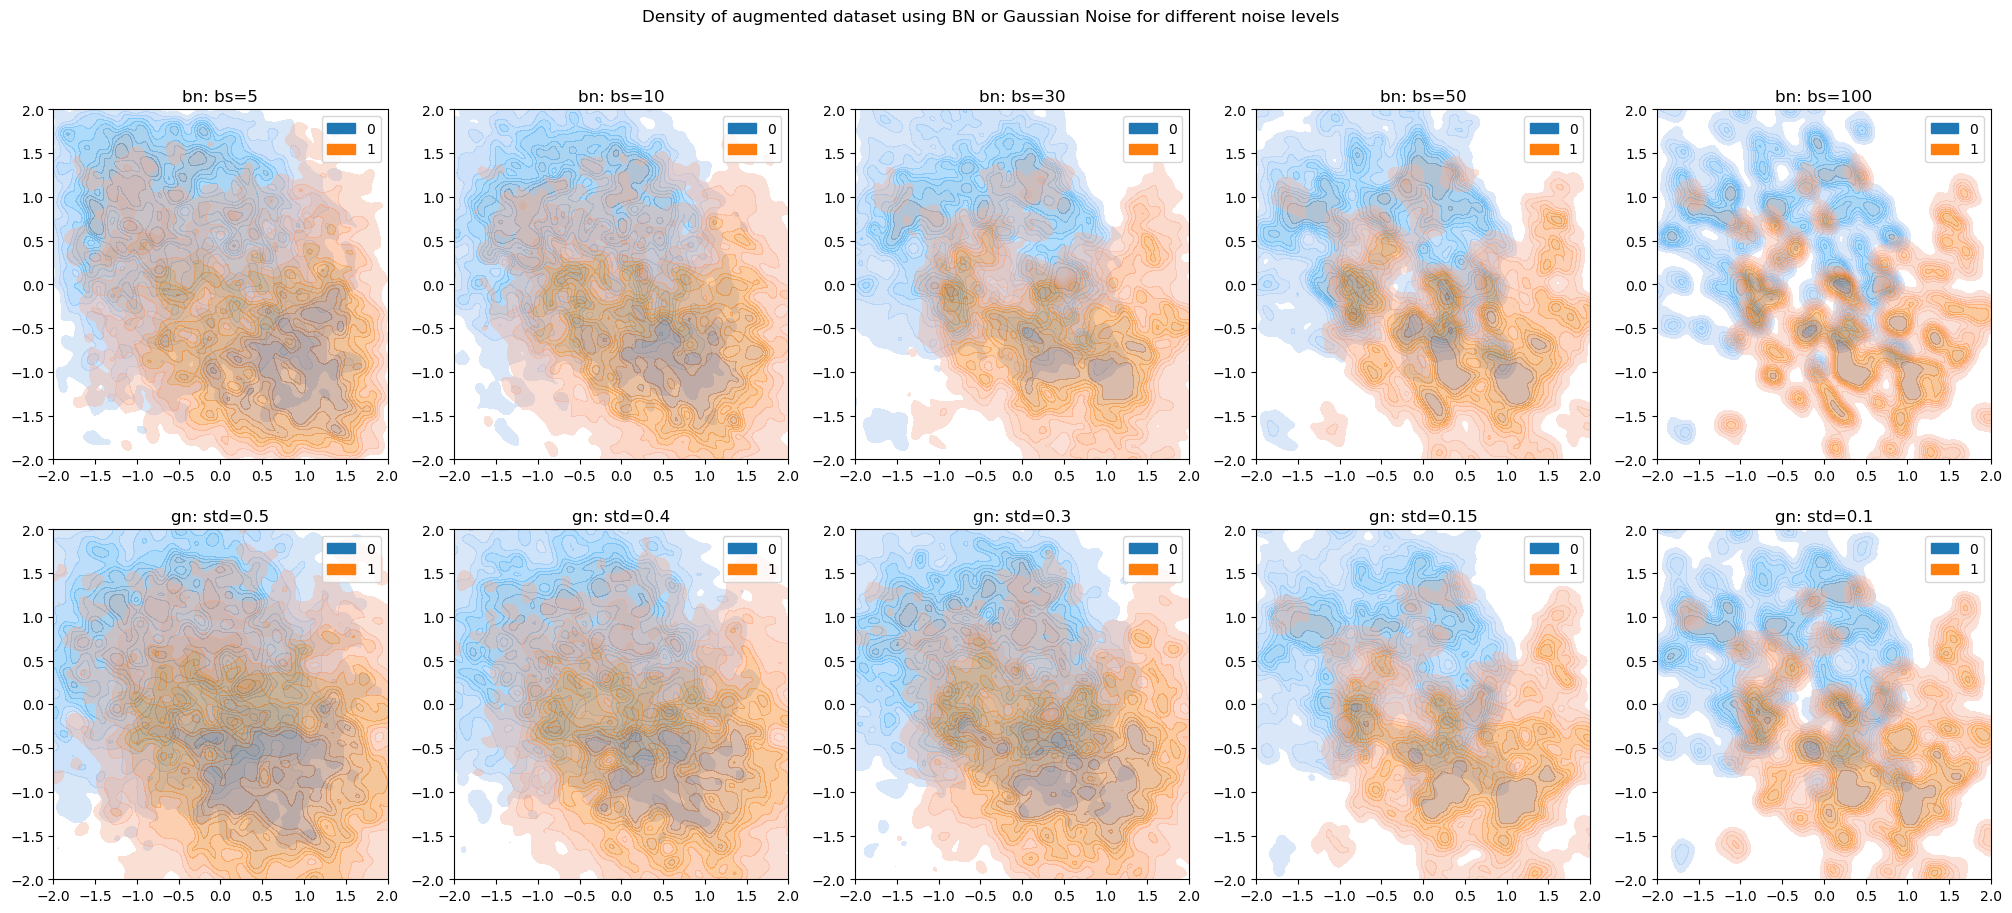

In [97]:
fig, axarr = plt.subplots(2, 5, figsize=(25, 10))
fig.suptitle("Density of augmented dataset using BN or Gaussian Noise for different noise levels")

X, y = get_data(n_samples=200, noise=0.4)

for ix, batch_size in enumerate([5, 10, 30, 50, 100]):
    ax = axarr[0, ix]
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_title(f"bn: bs={batch_size}")
    np.random.seed(0)
    Xs, ys = get_batches(X, y, batch_size=batch_size, n_samples=10000)
    Xs = batch_normalise(Xs)
    Xs = np.concatenate(Xs)
    ys = np.concatenate(ys)
    sns.kdeplot(x=Xs[:, 0], y=Xs[:, 1], hue=ys, fill=True, alpha=0.4, ax=ax, bw_adjust=0.3, common_norm=True)


for ix, std in enumerate([0.5, 0.4, 0.3, 0.15, 0.1]):
    ax = axarr[1, ix]
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_title(f"gn: std={std}")
    np.random.seed(0)
    Xs, ys = get_batches(X, y, batch_size=batch_size, n_samples=10000)
    Xs = gaussian_noise(Xs, std=std)
    Xs = np.concatenate(Xs)
    ys = np.concatenate(ys)
    sns.kdeplot(x=Xs[:, 0], y=Xs[:, 1], hue=ys, fill=True, alpha=0.4, ax=ax, bw_adjust=0.3, common_norm=True)


# 4. Effects on Decision Boundary
- Augmentation doesn't really have an impact on decision boundary if it is sampled too far from it
- Increasing noise and number of augmented samples [20x] to accentuate effects
- Will be using a very simple 2 layer model trained on non-stochastic gradient descent to generate the boundary
- Again, from a qualitative point of view the results look very similar
- They are not the same, however they show the same big picture
- At this point I am not sure what toy example I can create that would show where exactly they are different
- Performance on actual benchmarks is outside of the scope of this quick analysis

In [88]:
import torch
from torch import nn, optim


def plot_decision_boundary(X, y, ax=None):
    if ax is None:
        _, ax = plt.subplots(1,1)

    X = torch.tensor(X).float()
    y = torch.tensor(y).float().unsqueeze(1)

    torch.manual_seed(0)
    model = nn.Sequential(*[nn.Linear(2, 1000), nn.ReLU(), nn.Linear(1000, 1), nn.Sigmoid()])

    criterion = nn.BCELoss()
    optimiser = optim.Adam(model.parameters(), lr=1e-1)

    for epoch in range(1000):
        optimiser.zero_grad()
        out = model(X)
        loss = criterion(out, y)
        loss.backward()
        optimiser.step()

    xx, yy = np.meshgrid(np.arange(-2, 2, 0.1), np.arange(-2, 2, 0.1))
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()]).float()
    Z = model(grid).detach().numpy()
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu, alpha=0.5)

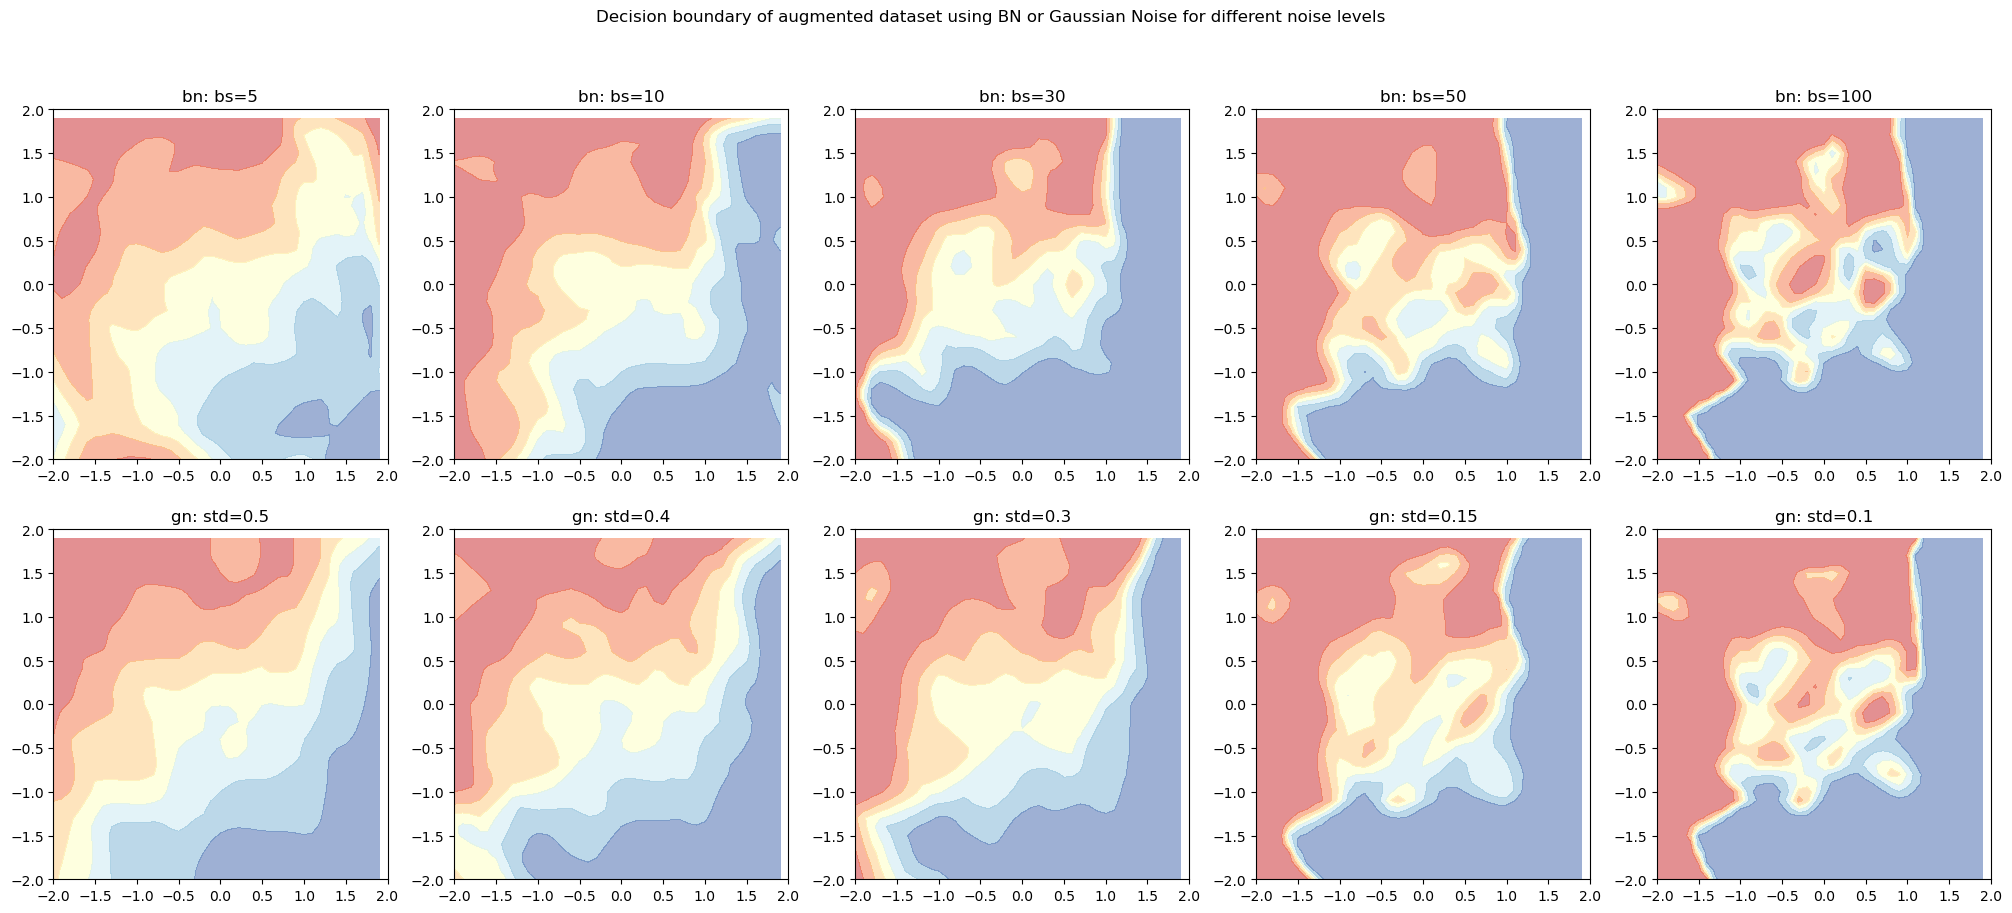

In [98]:
fig, axarr = plt.subplots(2, 5, figsize=(25, 10))
fig.suptitle("Decision boundary of augmented dataset using BN or Gaussian Noise for different noise levels")
X, y = get_data(n_samples=200, noise=0.5)

for ix, batch_size in enumerate([5, 10, 30, 50, 100]):
    ax = axarr[0, ix]
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_title(f"bn: bs={batch_size}")
    np.random.seed(0)
    Xs, ys = get_batches(X, y, batch_size=batch_size, n_samples=5000)
    Xs = batch_normalise(Xs)
    Xs = np.concatenate(Xs)
    ys = np.concatenate(ys)
    plot_decision_boundary(Xs, ys, ax=ax)
    

for ix, std in enumerate([0.5, 0.4, 0.3, 0.15, 0.1]):
    ax = axarr[1, ix]
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_title(f"gn: std={std}")
    np.random.seed(0)
    Xs, ys = get_batches(X, y, batch_size=batch_size, n_samples=5000)
    Xs = gaussian_noise(Xs, std=std)
    Xs = np.concatenate(Xs)
    ys = np.concatenate(ys)
    plot_decision_boundary(Xs, ys, ax=ax)